In [20]:
#!/usr/bin/env python3
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)


(True, 'NVIDIA GeForce RTX 2080 Ti')

In [21]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import soundfile as sf
import webrtcvad

from pyannote.audio import Pipeline



In [22]:
participant_id = "ABAN141223"
session_date   = "20250216"

session_dir = Path("/scratch/users/arunps/hindibabynet/audio_raw/ABAN141223/20250216")
wav_files = sorted(session_dir.glob("*.WAV")) + sorted(session_dir.glob("*.wav"))

wav_path = Path(wav_files[1])  # choose which file
info = sf.info(str(wav_path))
print(wav_path.name, info.samplerate, info.channels, info.duration/3600, "hours")
recording_id = wav_path.stem

# diarization bounds
MIN_SPEAKERS = 2
MAX_SPEAKERS = 4

# chunking
CHUNK_SEC   = 15 * 60  # 15 min
OVERLAP_SEC = 10       # overlap (you can set 19 if you want)

# VAD params
VAD_AGGR = 2
VAD_FRAME_MS = 30
VAD_MIN_REGION_MS = 300

# intersection / post-filter
MIN_KEEP_SEC = 0.20


1739701628.WAV 16000 1 2.0364166666666668 hours


In [23]:
rows = []
for p in wav_files:
    info = sf.info(str(p))
    rows.append({
        "participant_id": participant_id,
        "session_date": session_date,
        "recording_id": p.stem,
        "path": str(p),
        "duration_sec": float(info.duration),
        "sample_rate": int(info.samplerate),
        "channels": int(info.channels),
        "size_bytes": p.stat().st_size,
    })

recordings = pd.DataFrame(rows)
recordings


,participant_id,session_date,recording_id,path,duration_sec,sample_rate,channels,size_bytes
0,ABAN141223,20250216,1739683525,/scratch/users/arunps/hindibabynet/audio_raw/A...,17940.02,16000,1,574081152
1,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,7331.10,16000,1,234595712


In [24]:
from dotenv import load_dotenv
load_dotenv()

assert os.getenv("HF_TOKEN") is not None, "HF_TOKEN not loaded"
HF_TOKEN = os.environ["HF_TOKEN"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [25]:
os.environ["PYANNOTE_DISABLE_NOTEBOOK"] = "1"

scratch_cache = f"/scratch/users/{os.environ['USER']}/.cache/huggingface"
os.environ["HF_HOME"] = scratch_cache
os.environ["HF_HUB_CACHE"] = f"{scratch_cache}/hub"
os.environ["TRANSFORMERS_CACHE"] = f"{scratch_cache}/transformers"


In [26]:
pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token=HF_TOKEN
)
pipeline.to(device)
print("Diarization pipeline loaded on", device)


/itf-fi-ml/home/arunps/Projects/HindiBabyNet/.venv/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:73: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Diarization pipeline loaded on cuda


In [27]:
def make_chunks(duration_sec: float, chunk_sec: float, overlap_sec: float):
    """Yield (chunk_id, chunk_start, chunk_end) with overlap."""
    step = chunk_sec - overlap_sec
    assert step > 0, "chunk_sec must be > overlap_sec"

    t = 0.0
    chunk_id = 0
    while t < duration_sec:
        s = t
        e = min(t + chunk_sec, duration_sec)
        yield chunk_id, s, e
        if e >= duration_sec:
            break
        t += step
        chunk_id += 1


In [28]:
def webrtc_vad_regions_streaming(
    path: Path,
    aggressiveness: int = 2,
    frame_ms: int = 30,
    min_region_ms: int = 300,
):
    vad = webrtcvad.Vad(aggressiveness)
    info = sf.info(str(path))
    sr = info.samplerate

    if sr not in (8000, 16000, 32000, 48000):
        raise ValueError(f"webrtcvad needs sr in (8k,16k,32k,48k). got: {sr}")

    frame_len = int(sr * frame_ms / 1000)

    speech_flags = []
    with sf.SoundFile(str(path), mode="r") as f:
        while True:
            frame = f.read(frames=frame_len, dtype="int16", always_2d=True)
            if frame.size == 0 or len(frame) < frame_len:
                break
            mono = frame[:, 0]  # channel 0
            speech_flags.append(vad.is_speech(mono.tobytes(), sr))

    # merge consecutive True flags
    regions = []
    in_speech = False
    start_i = 0
    for i, is_speech in enumerate(speech_flags):
        if is_speech and not in_speech:
            in_speech = True
            start_i = i
        elif (not is_speech) and in_speech:
            in_speech = False
            regions.append((start_i, i))
    if in_speech:
        regions.append((start_i, len(speech_flags)))

    out = []
    for s_i, e_i in regions:
        s = (s_i * frame_len) / sr
        e = (e_i * frame_len) / sr
        if (e - s) * 1000 >= min_region_ms:
            out.append((float(s), float(e)))
    return out


In [29]:
info = sf.info(str(wav_path))
full_duration = float(info.duration)

vad_intervals = webrtc_vad_regions_streaming(
    wav_path,
    aggressiveness=VAD_AGGR,
    frame_ms=VAD_FRAME_MS,
    min_region_ms=VAD_MIN_REGION_MS
)

print("Full duration (hours):", full_duration / 3600)
print("VAD intervals:", len(vad_intervals), "first:", vad_intervals[:3])

vad_df = (
    pd.DataFrame([{
        "participant_id": participant_id,
        "session_date": session_date,
        "recording_id": recording_id,
        "wav_path": str(wav_path),
        "start_sec": s,
        "end_sec": e,
        "duration_sec": e - s,
    } for s, e in vad_intervals])
    .sort_values(["start_sec", "end_sec"])
    .reset_index(drop=True)
)
vad_df.head()


Full duration (hours): 2.0364166666666668
VAD intervals: 1745 first: [(2.43, 2.76), (7.71, 10.02), (11.1, 11.91)]


,participant_id,session_date,recording_id,wav_path,start_sec,end_sec,duration_sec
0,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,2.43,2.76,0.33
1,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,7.71,10.02,2.31
2,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,11.10,11.91,0.81
3,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,13.32,14.61,1.29
4,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,15.09,15.60,0.51


In [30]:
def write_wav_chunk(wav_path: Path, chunk_path: Path, start_sec: float, end_sec: float):
    info = sf.info(str(wav_path))
    sr = info.samplerate

    start_frame = int(start_sec * sr)
    n_frames = int((end_sec - start_sec) * sr)

    audio, _ = sf.read(str(wav_path), start=start_frame, frames=n_frames)
    sf.write(str(chunk_path), audio, sr)
    return chunk_path


In [31]:
all_turn_rows = []

tmp_chunks_dir = Path("/scratch/users") / Path.home().name / "hindibabynet_tmp_chunks"
tmp_chunks_dir.mkdir(parents=True, exist_ok=True)

for chunk_id, chunk_start, chunk_end in make_chunks(full_duration, CHUNK_SEC, OVERLAP_SEC):

    chunk_wav = tmp_chunks_dir / f"{wav_path.stem}_chunk{chunk_id:04d}_{int(chunk_start)}_{int(chunk_end)}.wav"
    write_wav_chunk(wav_path, chunk_wav, chunk_start, chunk_end)

    diar_chunk = pipeline(
        {"audio": str(chunk_wav)},
        min_speakers=MIN_SPEAKERS,
        max_speakers=MAX_SPEAKERS
    )

    for seg, _, spk in diar_chunk.itertracks(yield_label=True):
        # convert chunk-local to GLOBAL times
        s = float(seg.start) + float(chunk_start)
        e = float(seg.end) + float(chunk_start)
        if e <= s:
            continue

        all_turn_rows.append({
            "participant_id": participant_id,
            "session_date": session_date,
            "recording_id": recording_id,
            "wav_path": str(wav_path),
            "chunk_id": int(chunk_id),
            "chunk_start_sec": float(chunk_start),
            "chunk_end_sec": float(chunk_end),
            "speaker_id_local": spk,   
            "start_sec": s,
            "end_sec": e,
            "duration_sec": float(e - s),
            "chunk_wav_path": str(chunk_wav),
        })

print("Turns collected:", len(all_turn_rows))

turns_df = (
    pd.DataFrame(all_turn_rows)
      .sort_values(["start_sec", "end_sec"])
      .reset_index(drop=True)
)
turns_df.head()


/itf-fi-ml/home/arunps/Projects/HindiBabyNet/.venv/lib/python3.10/site-packages/pyannote/audio/utils/reproducibility.py:74: ReproducibilityWarning: TensorFloat-32 (TF32) has been disabled as it might lead to reproducibility issues and lower accuracy.
It can be re-enabled by calling
   >>> import torch
   >>> torch.backends.cuda.matmul.allow_tf32 = True
   >>> torch.backends.cudnn.allow_tf32 = True
See https://github.com/pyannote/pyannote-audio/issues/1370 for more details.

  warnings.warn(
/itf-fi-ml/home/arunps/Projects/HindiBabyNet/.venv/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  std = sequences.std(dim=-1, correction=1)


Turns collected: 1178


,participant_id,session_date,recording_id,wav_path,chunk_id,chunk_start_sec,chunk_end_sec,speaker_id_local,start_sec,end_sec,duration_sec,chunk_wav_path
0,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,0,0.0,900.0,SPEAKER_01,7.624719,9.885969,2.261250,/scratch/users/arunps/hindibabynet_tmp_chunks/...
1,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,0,0.0,900.0,SPEAKER_01,13.294719,14.273469,0.978750,/scratch/users/arunps/hindibabynet_tmp_chunks/...
2,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,0,0.0,900.0,SPEAKER_01,18.728469,20.095344,1.366875,/scratch/users/arunps/hindibabynet_tmp_chunks/...
3,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,0,0.0,900.0,SPEAKER_01,20.770344,22.002219,1.231875,/scratch/users/arunps/hindibabynet_tmp_chunks/...
4,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,0,0.0,900.0,SPEAKER_01,22.255344,23.807844,1.552500,/scratch/users/arunps/hindibabynet_tmp_chunks/...


In [35]:
def intersect_turns_with_vad(turns_df: pd.DataFrame, vad_intervals, min_keep_sec: float = 0.0):
    # ensure sorted
    turns_df = turns_df.sort_values(["start_sec", "end_sec"]).reset_index(drop=True)
    diar_arr = turns_df[["start_sec", "end_sec", "chunk_id", "speaker_id_local"]].to_numpy()
    vad_arr = np.array(sorted(vad_intervals), dtype=float)

    i = 0
    j = 0
    rows = []

    def intersect(a_s, a_e, b_s, b_e):
        s = max(a_s, b_s)
        e = min(a_e, b_e)
        return (s, e) if s < e else None

    while i < len(diar_arr) and j < len(vad_arr):
        ds, de, cid, spk = diar_arr[i]
        vs, ve = vad_arr[j]

        inter = intersect(ds, de, vs, ve)
        if inter is not None:
            s, e = inter
            dur = float(e - s)
            if dur >= min_keep_sec:
                rows.append({
                    "start_sec": float(s),
                    "end_sec": float(e),
                    "duration_sec": dur,
                    "chunk_id": int(cid),
                    "speaker_id_local": str(spk),
                })

        if de <= ve:
            i += 1
        else:
            j += 1

    return pd.DataFrame(rows)


In [36]:
speech_only_df = intersect_turns_with_vad(
    turns_df=turns_df,
    vad_intervals=vad_intervals,
    min_keep_sec=MIN_KEEP_SEC
)

# attach metadata
speech_only_df.insert(0, "wav_path", str(wav_path))
speech_only_df.insert(0, "recording_id", recording_id)
speech_only_df.insert(0, "session_date", session_date)
speech_only_df.insert(0, "participant_id", participant_id)

final_df_full = speech_only_df[[
    "participant_id","session_date","recording_id","wav_path",
    "chunk_id","start_sec","end_sec","duration_sec",
    "speaker_id_local"
]].sort_values(["start_sec","end_sec"]).reset_index(drop=True)

final_df_full.head(), len(final_df_full)


(  participant_id session_date recording_id  \
 0     ABAN141223     20250216   1739701628   
 1     ABAN141223     20250216   1739701628   
 2     ABAN141223     20250216   1739701628   
 3     ABAN141223     20250216   1739701628   
 4     ABAN141223     20250216   1739701628   
 
                                             wav_path  chunk_id  start_sec  \
 0  /scratch/users/arunps/hindibabynet/audio_raw/A...         0   7.710000   
 1  /scratch/users/arunps/hindibabynet/audio_raw/A...         0  13.320000   
 2  /scratch/users/arunps/hindibabynet/audio_raw/A...         0  18.728469   
 3  /scratch/users/arunps/hindibabynet/audio_raw/A...         0  20.790000   
 4  /scratch/users/arunps/hindibabynet/audio_raw/A...         0  22.320000   
 
      end_sec  duration_sec speaker_id_local  
 0   9.885969      2.175969       SPEAKER_01  
 1  14.273469      0.953469       SPEAKER_01  
 2  20.095344      1.366875       SPEAKER_01  
 3  22.002219      1.212219       SPEAKER_01  
 4  23.8078

In [39]:
final_df_full.tail(20)

,participant_id,session_date,recording_id,wav_path,chunk_id,start_sec,end_sec,duration_sec,speaker_id_local
969,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,8,7277.120344,7279.600969,2.480625,SPEAKER_01
970,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,8,7280.410969,7280.697844,0.286875,SPEAKER_01
971,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,8,7281.423469,7284.510000,3.086531,SPEAKER_01
972,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,8,7284.540000,7288.710000,4.170000,SPEAKER_01
973,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,8,7288.860000,7289.340000,0.480000,SPEAKER_01
974,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,8,7289.979094,7296.172219,6.193125,SPEAKER_01
975,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,8,7291.025344,7291.734094,0.708750,SPEAKER_00
976,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,8,7292.324719,7293.421594,1.096875,SPEAKER_00
977,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,8,7294.417219,7295.463469,1.046250,SPEAKER_00
978,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,8,7297.606594,7299.960000,2.353406,SPEAKER_01


In [34]:
final_df_full.groupby(["chunk_id", "speaker_id_local"])["duration_sec"].sum().sort_values(ascending=False).head(20)

chunk_id  speaker_id_local
7         SPEAKER_02          400.136031
6         SPEAKER_01          319.898281
5         SPEAKER_03          233.770969
8         SPEAKER_01          146.016375
7         SPEAKER_00           34.040625
          SPEAKER_01           32.440063
8         SPEAKER_00           31.674375
4         SPEAKER_00           30.663094
0         SPEAKER_01           28.093437
7         SPEAKER_03           27.453094
4         SPEAKER_01           26.408187
6         SPEAKER_00           22.366094
5         SPEAKER_00           17.662500
          SPEAKER_02           16.000687
          SPEAKER_01           14.586937
4         SPEAKER_03           11.323125
3         SPEAKER_01           10.335969
0         SPEAKER_00            9.669438
1         SPEAKER_01            5.613750
3         SPEAKER_00            5.383125
Name: duration_sec, dtype: float64

In [40]:
import numpy as np
import pandas as pd

dur = final_df_full["duration_sec"].astype(float)

summary = dur.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).to_frame().T
summary


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
duration_sec,989.0,1.45477,1.264572,0.200281,0.219375,0.27,0.347275,0.57375,1.08,1.9575,2.970569,4.093875,6.205003,11.97


In [41]:
thresholds = [0.2, 0.3, 0.5, 0.8, 1.0, 2.0, 5.0]

counts = []
n = len(dur)
for t in thresholds:
    counts.append({
        "threshold_sec": t,
        "n_segments": int((dur < t).sum()),
        "pct_segments": float((dur < t).mean() * 100),
    })

pd.DataFrame(counts)


,threshold_sec,n_segments,pct_segments
0,0.2,0,0.000000
1,0.3,70,7.077856
2,0.5,191,19.312437
3,0.8,377,38.119312
4,1.0,475,48.028311
5,2.0,748,75.631951
6,5.0,965,97.573306


In [42]:
bins = [0, 0.2, 0.5, 1, 2, 5, 10, np.inf]
labels = ["<0.2", "0.2-0.5", "0.5-1", "1-2", "2-5", "5-10", "10+"]

tmp = final_df_full.copy()
tmp["dur_bin"] = pd.cut(tmp["duration_sec"], bins=bins, labels=labels, right=False)

by_bin = (
    tmp.groupby("dur_bin")
       .agg(
           n_segments=("duration_sec", "size"),
           total_sec=("duration_sec", "sum"),
           mean_sec=("duration_sec", "mean"),
           median_sec=("duration_sec", "median"),
       )
       .reset_index()
)

by_bin["pct_segments"] = by_bin["n_segments"] / by_bin["n_segments"].sum() * 100
by_bin["pct_time"] = by_bin["total_sec"] / by_bin["total_sec"].sum() * 100

by_bin.sort_values("dur_bin")


/tmp/ipykernel_4050503/1767810938.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby("dur_bin")


,dur_bin,n_segments,total_sec,mean_sec,median_sec,pct_segments,pct_time
0,<0.2,0,0.000000,NaN,NaN,0.000000,0.000000
1,0.2-0.5,191,65.332344,0.342054,0.337500,19.312437,4.540856
2,0.5-1,284,205.460969,0.723454,0.708750,28.715875,14.280349
3,1-2,273,395.385594,1.448299,1.417500,27.603640,27.480861
4,2-5,217,621.291688,2.863095,2.615625,21.941355,43.182227
5,5-10,23,139.326531,6.057675,6.140281,2.325581,9.683744
6,10+,1,11.970000,11.970000,11.970000,0.101112,0.831962


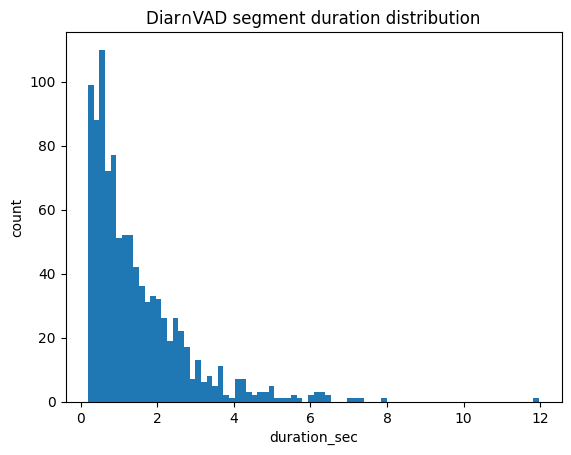

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.hist(dur, bins=80)
plt.xlabel("duration_sec")
plt.ylabel("count")
plt.title("Diar∩VAD segment duration distribution")
plt.show()


In [45]:
grp = (
    final_df_full
    .groupby(["chunk_id", "speaker_id_local"])["duration_sec"]
    .agg(["count", "sum", "mean", "median", "max"])
    .sort_values("sum", ascending=False)
)

grp.head(20)


count         sum      mean    median        max
chunk_id speaker_id_local                                                  
7        SPEAKER_02          242  400.136031  1.653455  1.238781  11.970000
6        SPEAKER_01          190  319.898281  1.683675  1.384234   7.860000
5        SPEAKER_03          155  233.770969  1.508200  1.299375   7.347844
8        SPEAKER_01           65  146.016375  2.246406  1.650000   7.121250
7        SPEAKER_00           38   34.040625  0.895806  0.573750   5.956875
         SPEAKER_01           22   32.440063  1.474548  1.063125   4.387500
8        SPEAKER_00           33   31.674375  0.959830  0.675000   5.602500
4        SPEAKER_00           24   30.663094  1.277629  0.954547   3.384719
0        SPEAKER_01           17   28.093437  1.652555  1.366875   4.244031
7        SPEAKER_03           21   27.453094  1.307290  1.282500   3.532844
4        SPEAKER_01           21   26.408187  1.257533  0.961875   3.611250
6        SPEAKER_00           36   22.366094  0.621280  0.531562   1.373469
5        SPEAKER_00           24   17.662500  0.735938  0.734063   1.704375
         SPEAKER_02           17   16.000687  0.941217  0.658125   2.740969
         SPEAKER_01           17   14.586937  0.858055  0.661594   2.109375
4        SPEAKER_03            9   11.323125  1.258125  1.046250   3.611250
3        SPEAKER_01           13   10.335969  0.795075  0.590625   3.307500
0        SPEAKER_00           14    9.669438  0.690674  0.615937   2.244375
1        SPEAKER_01            5    5.613750  1.122750  0.590625   2.227500
3        SPEAKER_00            6    5.383125  0.897188  0.767813   1.569375

In [48]:
import pandas as pd

df = final_df_full.copy()

overlap_rows = []

for chunk_id, g in df.groupby("chunk_id"):
    g = g.sort_values("start_sec").reset_index(drop=True)

    for i in range(len(g)):
        si, ei, spki = g.loc[i, ["start_sec", "end_sec", "speaker_id_local"]]

        for j in range(i + 1, len(g)):
            sj, ej, spkj = g.loc[j, ["start_sec", "end_sec", "speaker_id_local"]]

            # stop early (sorted by start time)
            if sj >= ei:
                break

            if spki != spkj:
                overlap_start = max(si, sj)
                overlap_end = min(ei, ej)

                if overlap_end > overlap_start:
                    overlap_rows.append({
                        "chunk_id": chunk_id,
                        "speaker_1": spki,
                        "speaker_2": spkj,
                        "seg1_start": si,
                        "seg1_end": ei,
                        "seg2_start": sj,
                        "seg2_end": ej,
                        "overlap_start": overlap_start,
                        "overlap_end": overlap_end,
                        "overlap_dur": overlap_end - overlap_start,
                    })


In [49]:
overlap_df = pd.DataFrame(overlap_rows)

len(overlap_df), overlap_df.head()


(91,
    chunk_id   speaker_1   speaker_2   seg1_start     seg1_end   seg2_start  \
 0         0  SPEAKER_01  SPEAKER_00    33.021594    35.839719    35.215344   
 1         2  SPEAKER_01  SPEAKER_00  1811.789719  1813.257844  1812.414094   
 2         3  SPEAKER_01  SPEAKER_00  3092.640000  3093.576594  3092.682219   
 3         5  SPEAKER_03  SPEAKER_02  4946.640000  4950.847219  4948.197844   
 4         5  SPEAKER_03  SPEAKER_02  4954.255969  4954.897219  4954.289719   
 
       seg2_end  overlap_start  overlap_end  overlap_dur  
 0    35.822844      35.215344    35.822844     0.607500  
 1  1812.751594    1812.414094  1812.751594     0.337500  
 2  3093.357219    3092.682219  3093.357219     0.675000  
 3  4949.733469    4948.197844  4949.733469     1.535625  
 4  4954.610344    4954.289719  4954.610344     0.320625  )

In [51]:
overlap_df.head(20)

,chunk_id,speaker_1,speaker_2,seg1_start,seg1_end,seg2_start,seg2_end,overlap_start,overlap_end,overlap_dur
0,0,SPEAKER_01,SPEAKER_00,33.021594,35.839719,35.215344,35.822844,35.215344,35.822844,0.607500
1,2,SPEAKER_01,SPEAKER_00,1811.789719,1813.257844,1812.414094,1812.751594,1812.414094,1812.751594,0.337500
2,3,SPEAKER_01,SPEAKER_00,3092.640000,3093.576594,3092.682219,3093.357219,3092.682219,3093.357219,0.675000
3,5,SPEAKER_03,SPEAKER_02,4946.640000,4950.847219,4948.197844,4949.733469,4948.197844,4949.733469,1.535625
4,5,SPEAKER_03,SPEAKER_02,4954.255969,4954.897219,4954.289719,4954.610344,4954.289719,4954.610344,0.320625
5,5,SPEAKER_03,SPEAKER_02,4955.032219,4956.399094,4955.386594,4956.044719,4955.386594,4956.044719,0.658125
6,5,SPEAKER_03,SPEAKER_00,4968.633469,4970.371594,4968.734719,4968.937219,4968.734719,4968.937219,0.202500
7,5,SPEAKER_03,SPEAKER_00,5119.749094,5122.347844,5120.879719,5121.706594,5120.879719,5121.706594,0.826875
8,5,SPEAKER_03,SPEAKER_01,5134.362844,5136.472219,5135.139094,5135.527219,5135.139094,5135.527219,0.388125
9,5,SPEAKER_02,SPEAKER_03,5219.547844,5220.222844,5219.834719,5221.080000,5219.834719,5220.222844,0.388125


In [52]:
overlap_df["overlap_dur"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])


count    91.000000
mean      0.741573
std       0.551332
min       0.067500
50%       0.607500
75%       0.978750
90%       1.468125
95%       1.864687
99%       2.575125
max       2.666250
Name: overlap_dur, dtype: float64

In [53]:
segments_in_overlap = pd.concat([
    overlap_df[["chunk_id", "speaker_1", "seg1_start", "seg1_end"]]
        .rename(columns={"speaker_1": "speaker_id_local",
                          "seg1_start": "start_sec",
                          "seg1_end": "end_sec"}),

    overlap_df[["chunk_id", "speaker_2", "seg2_start", "seg2_end"]]
        .rename(columns={"speaker_2": "speaker_id_local",
                          "seg2_start": "start_sec",
                          "seg2_end": "end_sec"})
]).drop_duplicates()

len(segments_in_overlap)


163

In [54]:
len(segments_in_overlap) / len(df) * 100


16.48129423660263

In [55]:
bins = [0, 0.2, 0.5, 1, 2, 5, 10]
labels = ["<0.2", "0.2-0.5", "0.5-1", "1-2", "2-5", "5+"]

overlap_df["dur_bin"] = pd.cut(
    overlap_df["overlap_dur"],
    bins=bins,
    labels=labels,
    right=False
)

(
    overlap_df
    .groupby("dur_bin")
    .agg(
        n_overlaps=("overlap_dur", "size"),
        total_overlap_sec=("overlap_dur", "sum"),
    )
    .assign(
        pct_overlaps=lambda x: x["n_overlaps"] / x["n_overlaps"].sum() * 100,
        pct_time=lambda x: x["total_overlap_sec"] / x["total_overlap_sec"].sum() * 100,
    )
    .sort_index()
)


/tmp/ipykernel_4050503/2224223659.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("dur_bin")


,n_overlaps,total_overlap_sec,pct_overlaps,pct_time
dur_bin,,,,
<0.2,1,0.067500,1.098901,0.100025
0.2-0.5,36,11.728125,39.560440,17.379345
0.5-1,32,21.988125,35.164835,32.583146
1-2,18,23.591250,19.780220,34.958740
2-5,4,10.108125,4.395604,14.978745
5+,0,0.000000,0.000000,0.000000


In [56]:
overlap_df.sort_values("overlap_dur", ascending=False).head(10)


,chunk_id,speaker_1,speaker_2,seg1_start,seg1_end,seg2_start,seg2_end,overlap_start,overlap_end,overlap_dur,dur_bin
87,8,SPEAKER_01,SPEAKER_00,7271.619094,7275.196594,7271.669719,7274.335969,7271.669719,7274.335969,2.666250,2-5
43,7,SPEAKER_00,SPEAKER_02,6870.808469,6876.765344,6874.200344,6878.317844,6874.200344,6876.765344,2.565000,2-5
76,8,SPEAKER_01,SPEAKER_00,7213.214719,7215.999094,7213.265344,7215.712219,7213.265344,7215.712219,2.446875,2-5
47,7,SPEAKER_02,SPEAKER_01,7052.640000,7055.977844,7053.007844,7055.437844,7053.007844,7055.437844,2.430000,2-5
13,5,SPEAKER_03,SPEAKER_01,5339.910000,5347.257844,5342.549719,5344.439719,5342.549719,5344.439719,1.890000,1-2
42,7,SPEAKER_00,SPEAKER_02,6870.808469,6876.765344,6872.124719,6873.964094,6872.124719,6873.964094,1.839375,1-2
71,8,SPEAKER_01,SPEAKER_00,7182.063469,7185.877219,7183.194094,7184.763469,7183.194094,7184.763469,1.569375,1-2
83,8,SPEAKER_01,SPEAKER_00,7250.930344,7253.056594,7251.267844,7252.803469,7251.267844,7252.803469,1.535625,1-2
3,5,SPEAKER_03,SPEAKER_02,4946.640000,4950.847219,4948.197844,4949.733469,4948.197844,4949.733469,1.535625,1-2
85,8,SPEAKER_01,SPEAKER_00,7259.435344,7260.937219,7259.469094,7265.071594,7259.469094,7260.937219,1.468125,1-2


In [96]:
from pathlib import Path
import soundfile as sf
import pandas as pd
from praatio import textgrid as tgio


def _make_interval_tier(name, entries, xmin, xmax):
    """
    Create IntervalTier across praatio versions.
    """
    # IntervalTier(name, entries, minT, maxT)
    try:
        return tgio.IntervalTier(str(name), entries, xmin, xmax)
    except TypeError:
        pass

    # IntervalTier(name, entries=..., minT=..., maxT=...)
    try:
        return tgio.IntervalTier(name=str(name), entries=entries, minT=xmin, maxT=xmax)
    except TypeError:
        pass

    # IntervalTier(name, entryList=..., minT=..., maxT=...)
    return tgio.IntervalTier(name=str(name), entryList=entries, minT=xmin, maxT=xmax)


def df_to_textgrid_by_speaker(
    df: pd.DataFrame,
    wav_path: Path,
    out_textgrid_path: Path,
    start_col: str = "start_sec",
    end_col: str = "end_sec",
    speaker_col: str = "speaker_id",
    label_col: str | None = None,  # None -> label = speaker_id
):
    wav_path = Path(wav_path)
    out_textgrid_path = Path(out_textgrid_path)

    info = sf.info(str(wav_path))
    xmin = 0.0
    xmax = float(info.duration)

    df = df.copy()
    df = df[df[end_col] > df[start_col]].sort_values([speaker_col, start_col, end_col])

    tg = tgio.Textgrid()
    tg.minTimestamp = xmin
    tg.maxTimestamp = xmax

    for spk, g in df.groupby(speaker_col):
        entries = []
        for r in g.itertuples(index=False):
            s = float(getattr(r, start_col))
            e = float(getattr(r, end_col))

            # clamp
            s = max(xmin, min(s, xmax))
            e = max(xmin, min(e, xmax))
            if e <= s:
                continue

            lab = str(spk) if label_col is None else str(getattr(r, label_col))
            entries.append((s, e, lab))

        # ensure non-overlap within the speaker tier
        entries.sort(key=lambda x: (x[0], x[1]))
        cleaned = []
        last_end = -1.0
        for s, e, lab in entries:
            if s < last_end:
                s = last_end
            if e > s:
                cleaned.append((s, e, lab))
                last_end = e

        tier = _make_interval_tier(str(spk), cleaned, xmin, xmax)
        tg.addTier(tier)

    tg.save(str(out_textgrid_path), format="short_textgrid", includeBlankSpaces=True)
    return out_textgrid_path


In [97]:
import numpy as np

tmp_dir = Path("/scratch/users") / Path.home().name / "hindibabynet_tmp"
tmp_dir.mkdir(parents=True, exist_ok=True)

tg_path = df_to_textgrid_by_speaker(
    df=final_df_full,                         # diarization ∩ VAD DataFrame
    wav_path=wav_path,                   # full audio file
    out_textgrid_path=tmp_dir / f"{wav_path.stem}.TextGrid",
)

tg_path

PosixPath('/scratch/users/arunps/hindibabynet_tmp/1739683525.TextGrid')

In [98]:
# --------------------------
# CLEANUP: remove all chunk WAVs at once
# --------------------------
import shutil
from pathlib import Path

tmp_chunks_dir = Path("/scratch/users") / Path.home().name / "hindibabynet_tmp_chunks"

if tmp_chunks_dir.exists():
    shutil.rmtree(tmp_chunks_dir)
    print(f"Deleted temporary chunk directory: {tmp_chunks_dir}")
else:
    print("No temporary chunk directory found.")

Deleted temporary chunk directory: /scratch/users/arunps/hindibabynet_tmp_chunks
